**Этот ноутбук — упражнение из курса [Intro to Deep Learning](https://www.kaggle.com/learn/intro-to-deep-learning).  Справочник по уроку — по [этой ссылке](https://www.kaggle.com/ryanholbrook/stochastic-gradient-descent).**

---


# Введение #

В этом упражнении вы обучите нейронную сеть на наборе данных *Fuel Economy* и затем изучите влияние скорости обучения и размера батча на SGD.

Когда будете готовы, запустите следующую ячейку, чтобы все настроить!


In [1]:
import matplotlib.pyplot as plt

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)

В наборе данных *Fuel Economy* ваша задача — предсказать экономичность топлива автомобиля по таким признакам, как тип двигателя или год выпуска. 

Сначала загрузите набор данных, запустив ячейку ниже.


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split

fuel = pd.read_csv('../dataset/fuel.csv')

X = fuel.copy()
# Remove target
y = X.pop('FE')

preprocessor = make_column_transformer(
    (StandardScaler(),
     make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(sparse_output=False),
     make_column_selector(dtype_include=object)),
)

X = preprocessor.fit_transform(X)
y = np.log(y) # log transform target instead of standardizing

input_shape = [X.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [50]


При желании посмотрите на данные. Целевая переменная — столбец `'FE'`, остальные столбцы — признаки.


In [4]:
# Uncomment to see original data
fuel.head()
# Uncomment to see processed features
pd.DataFrame(X[:10,:]).head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.913643,1.068005,0.524148,0.685653,-0.226455,0.391659,0.43492,0.463841,-0.447941,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.913643,1.068005,0.524148,0.685653,-0.226455,0.391659,0.43492,0.463841,-0.447941,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.530594,1.068005,0.524148,0.685653,-0.226455,0.391659,0.43492,0.463841,-0.447941,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.530594,1.068005,0.524148,0.685653,-0.226455,0.391659,0.43492,0.463841,-0.447941,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.296693,2.120794,0.524148,-1.458464,-0.226455,0.391659,0.43492,0.463841,-0.447941,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Запустите следующую ячейку, чтобы определить сеть, которую мы будем использовать для этой задачи.


In [5]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(128, activation='relu'),    
    layers.Dense(64, activation='relu'),
    layers.Dense(1),
])

/Users/flexonafft/KaggleLearning/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/flexonafft/KaggleLearning/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,361 (122.50 KB)

 Trainable params: 31,361 (122.50 KB)

 Non-trainable params: 0 (0.00 B)

# 1) Добавьте функцию потерь и оптимизатор

Перед обучением сети нужно определить функцию потерь и оптимизатор. С помощью метода `compile` модели добавьте оптимизатор Adam и функцию потерь MAE.


In [7]:
# YOUR CODE HERE
model.compile(
    optimizer='adam',
    loss='mae'
)

In [ ]:
# Lines below will give you a hint or solution code
#q_1.hint()
#q_1.solution()

# 2) Обучите модель

После того как вы определили модель и скомпилировали ее с функцией потерь и оптимизатором, можно обучать. Обучите сеть 200 эпох с размером батча 128. Входные данные — `X`, целевая переменная — `y`.


In [8]:
# YOUR CODE HERE
history = model.fit(
    X, y, batch_size=128, epochs=200
)

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6112  
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0316
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5742
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3696
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2638
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2114
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1673
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1259
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1046
Epoch 10/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0888
Epoch 11/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0806
Epoch 12/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0751
Epoch 13/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0673
Epoch 14/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0664
Epoch 15/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0588
Epoch 16/200
9/9 ━━━━━━━━━━━━━━━

In [ ]:
# Lines below will give you a hint or solution code
#q_2.hint()
#q_2.solution()

Последний шаг — посмотреть на кривые потерь и оценить обучение. Запустите ячейку ниже, чтобы построить график потерь на обучении.


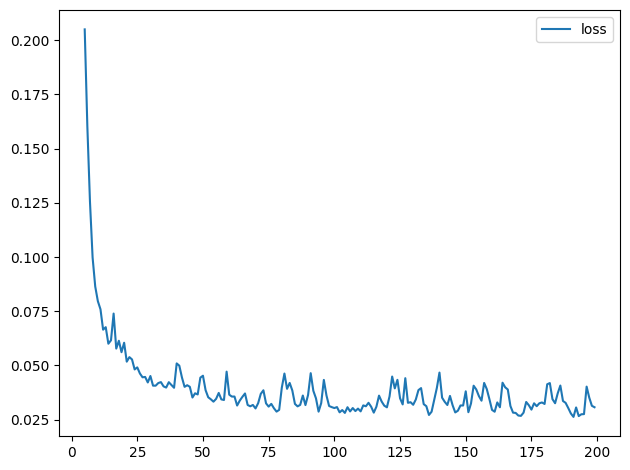

In [9]:
import pandas as pd

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5. You can change this to get a different view.
history_df.loc[5:, ['loss']].plot();

# 3) Оцените обучение

Если бы вы обучали модель дольше, ожидали бы вы дальнейшего уменьшения потерь?


С помощью скорости обучения и размера батча вы можете влиять на:
- Сколько времени занимает обучение модели
- Насколько шумными будут кривые обучения
- Насколько маленькой станет потеря

Чтобы лучше понять эти два параметра, рассмотрим линейную модель — нашу самую простую (ppsimplest) нейронную сеть. Имея всего один вес и смещение, легче увидеть, какой эффект оказывает изменение параметров.

Следующая ячейка сгенерирует анимацию, похожую на ту, что в уроке. Измените значения `learning_rate`, `batch_size` и `num_examples` (сколько точек данных), а затем запустите ячейку. (Это может занять минуту-другую.) Попробуйте следующие комбинации или свои варианты:

| `learning_rate` | `batch_size` | `num_examples` |
|-----------------|--------------|----------------|
| 0.05            | 32           | 256            |
| 0.05            | 2            | 256            |
| 0.05            | 128          | 256            |
| 0.02            | 32           | 256            |
| 0.2             | 32           | 256            |
| 1.0             | 32           | 256            |
| 0.9             | 4096         | 8192           |
| 0.99            | 4096         | 8192           |


In [ ]:
# YOUR CODE HERE: Experiment with different values for the learning rate, batch size, and number of examples
learning_rate = 0.05
batch_size = 32
num_examples = 256

animate_sgd(
    learning_rate=learning_rate,
    batch_size=batch_size,
    num_examples=num_examples,
    # You can also change these, if you like
    steps=50, # total training steps (batches seen)
    true_w=3.0, # the slope of the data
    true_b=2.0, # the bias of the data
)

# 4) Скорость обучения и размер батча

Какой эффект оказало изменение этих параметров? Подумав, запустите ячейку ниже для обсуждения.


# Продолжайте #

Узнайте, как [**улучшить качество модели**](https://www.kaggle.com/ryanholbrook/overfitting-and-underfitting) с помощью настройки мощности или добавления ранней остановки.


---




*Есть вопросы или комментарии? Посетите [форум обсуждений курса](https://www.kaggle.com/learn/intro-to-deep-learning/discussion), чтобы пообщаться с другими учащимися.*
